In [1]:
import os
import pycocotools
os.getcwd()


'/content'

In [2]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [3]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from PIL import ImageDraw
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import torchvision
import xml.etree.ElementTree as ET
import glob

In [4]:
def extract_BBoxes(filename):
   
    root = ET.parse(filename).getroot()
    
    boxes = list()
    names = list()
    for objct in root.findall(".//object"):
        name = objct.find('name').text
        xmin = int(objct.find('bndbox/xmin').text)
        ymin = int(objct.find('bndbox/ymin').text)
        xmax = int(objct.find('bndbox/xmax').text)
        ymax = int(objct.find('bndbox/ymax').text)
        names.append(name)
        boxes.append([xmin,ymin,xmax,ymax])

    return [boxes,names]
    
def load_dataset(path, deleteFiles = False):
    files_xml = [f for f in glob.glob(path + "/*.xml")] # comes in random order

    
    imgbbox = dict()
    print(len(files_xml))
    for file in files_xml:  
        
        imgFilePath = file[:-3] + "jpg"
        if os.path.exists(imgFilePath):  
            lbl_bbox = extract_BBoxes(file)  # Gets the bbox information
            
            #print(lbl_bbox[0])
            
            imgbbox.update({imgFilePath.replace(path+"/",''): lbl_bbox})
            
        elif deleteFiles:
            print("Found xml with no jpg")
            print("Deleting xml file: %s" %file)
            os.remove(file)
            print("Deleted")

    return imgbbox

In [8]:
from google.colab import drive
drive.mount('/content/drive')
pathDataset = 'drive/MyDrive/Project2'
imgbbox = load_dataset(pathDataset, deleteFiles=False)
imgbbox['2 (20).jpg']


Mounted at /content/drive
535


[[[8, 143, 313, 292]], ['rifle']]

Obtaining the data

Class containing all data for training

In [9]:
class GunDataset(torch.utils.data.Dataset):
    
    def __init__(self, dicPics,categories, path, transforms=None): 
        self.path = path
        self.dicPics = dicPics
        self.transforms = transforms
        self.categories = categories
        self.imgs = [o for o in imgbbox]

    def __getitem__(self, idx):
        img = Image.open(self.path +"/"+ self.imgs[idx]).convert("RGB")        
        box_list = self.dicPics[self.imgs[idx]][0]
        
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        labels_list =  self.dicPics[self.imgs[idx]][1]

        # there is only one class
        #labels = torch.ones((num_objs,), dtype=torch.int64) 

        # multible classes
        labels = torch.zeros((num_objs,), dtype=torch.int64)

        for i in range(num_objs):
          labels[i] = self.categories[labels_list[i]]
        #print(labels)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
    
    def __len__(self):
        return len(self.imgs)

Checks if the class is correct and returns the expected values

In [10]:
cat = {'handgun': 1,'rifle': 2}
dataset = GunDataset(dicPics = imgbbox,categories = cat, path = pathDataset, transforms = None) #, categories = cat
dataset.__getitem__(10)

(<PIL.Image.Image image mode=RGB size=320x450 at 0x7F0D4077C5F8>,
 {'area': tensor([17316.]),
  'boxes': tensor([[ 73.,  79., 184., 235.]]),
  'image_id': tensor([10]),
  'iscrowd': tensor([0]),
  'labels': tensor([1])})

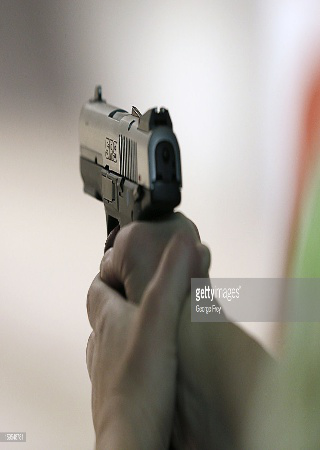

In [8]:
image = Image.open(pathDataset + '/1 (107).jpg')
image

Downloads and configures the model for our dataset

In [11]:
def get_model(num_classes):
  # load an object detection model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new on
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
  return model

In [12]:
def get_transform(train):
    transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [13]:
# use our dataset and defined transformations
dataset = GunDataset(dicPics=imgbbox, categories = cat, path = pathDataset, transforms = get_transform(train=True))      # Training
dataset_test = GunDataset(dicPics = imgbbox, categories = cat, path = pathDataset, transforms = get_transform(train=False)) # Testing

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])  
#dataset = torch.utils.data.Subset(dataset, indices[:100])  # testing

dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-30:])


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=4,
              collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=4,
         collate_fn=utils.collate_fn)

print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 535 examples, 495 are training and 40 testing


In [14]:
torch.cuda.is_available()

True

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - gun and not gun
num_classes = 3
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


## TRAIN NEW MODEL

In [76]:

num_epochs = 8
for epoch in range(num_epochs):
   # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
# update the learning rate

    lr_scheduler.step()
   # evaluate on the test dataset
   # evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/248]  eta: 0:04:26  lr: 0.000025  loss: 1.6075 (1.6075)  loss_classifier: 1.4709 (1.4709)  loss_box_reg: 0.1204 (0.1204)  loss_objectness: 0.0063 (0.0063)  loss_rpn_box_reg: 0.0099 (0.0099)  time: 1.0749  data: 0.4581  max mem: 4768
Epoch: [0]  [ 10/248]  eta: 0:02:28  lr: 0.000227  loss: 1.3823 (1.3332)  loss_classifier: 1.2312 (1.1476)  loss_box_reg: 0.1431 (0.1513)  loss_objectness: 0.0040 (0.0098)  loss_rpn_box_reg: 0.0135 (0.0245)  time: 0.6239  data: 0.0471  max mem: 4768
Epoch: [0]  [ 20/248]  eta: 0:02:18  lr: 0.000430  loss: 0.4939 (0.8671)  loss_classifier: 0.3847 (0.6981)  loss_box_reg: 0.1339 (0.1396)  loss_objectness: 0.0070 (0.0095)  loss_rpn_box_reg: 0.0085 (0.0200)  time: 0.5852  data: 0.0064  max mem: 4768
Epoch: [0]  [ 30/248]  eta: 0:02:12  lr: 0.000632  loss: 0.3283 (0.6935)  loss_classifier: 0.1781 (0.5313)  loss_box_reg: 0.1166 (0.1338)  loss_objectness: 0.0085 (0.0107)  loss_rpn_box_reg: 0.0084 (0.0177)  time: 0.5960  data: 0.0066  max mem: 4768


In [77]:
 # Saves model to folder trainedModels
    
path_trnd_model = "drive/MyDrive/trainedModels"
if os.path.isdir(path_trnd_model) is False:
    os.mkdir(path_trnd_model)

state = {'epoch': num_epochs +1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict() }
torch.save(state, path_trnd_model+"/model_3Classes_10epochs")

#torch.save(model.state_dict(), )

## TRAIN OLD MODEL

In [17]:
def load_checkpoint(model, optimizer=None, filename=None):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        if optimizer is not None:
          optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})".format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [79]:
model, optimizer, start_epoch = load_checkpoint(get_model(num_classes = 3), optimizer, filename=path_trnd_model+"/model_3Classes_20epochs")
model = model.to(device)

# individually transfer the optimizer parts...
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

=> loading checkpoint 'drive/MyDrive/trainedModels/model_3Classes_10epochs'
=> loaded checkpoint 'drive/MyDrive/trainedModels/model_3Classes_10epochs' (epoch 9)


In [80]:
# let's train it for 0 epochs
num_epochs = 12
for epoch in range(num_epochs):
   # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
# update the learning rate

    lr_scheduler.step()
   # evaluate on the test dataset
   # evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/248]  eta: 0:03:54  lr: 0.000025  loss: 0.1228 (0.1228)  loss_classifier: 0.0421 (0.0421)  loss_box_reg: 0.0706 (0.0706)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 0.9454  data: 0.3402  max mem: 4768
Epoch: [0]  [ 10/248]  eta: 0:02:22  lr: 0.000227  loss: 0.0561 (0.0783)  loss_classifier: 0.0196 (0.0239)  loss_box_reg: 0.0308 (0.0418)  loss_objectness: 0.0007 (0.0012)  loss_rpn_box_reg: 0.0028 (0.0114)  time: 0.5985  data: 0.0356  max mem: 4768
Epoch: [0]  [ 20/248]  eta: 0:02:12  lr: 0.000430  loss: 0.0555 (0.0678)  loss_classifier: 0.0192 (0.0215)  loss_box_reg: 0.0293 (0.0371)  loss_objectness: 0.0007 (0.0018)  loss_rpn_box_reg: 0.0022 (0.0074)  time: 0.5648  data: 0.0061  max mem: 4768
Epoch: [0]  [ 30/248]  eta: 0:02:05  lr: 0.000632  loss: 0.0577 (0.0740)  loss_classifier: 0.0199 (0.0233)  loss_box_reg: 0.0326 (0.0407)  loss_objectness: 0.0008 (0.0018)  loss_rpn_box_reg: 0.0021 (0.0082)  time: 0.5665  data: 0.0066  max mem: 4768


In [81]:
state = {'epoch': num_epochs +1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict() }
torch.save(state, path_trnd_model+"/model_3Classes_20epochs")

# PREDICT 

In [42]:
# To load trained model
path_trnd_model = "drive/MyDrive/trainedModels"
loaded_model,_,_ = load_checkpoint(get_model(num_classes = 3), filename=path_trnd_model+"/model_3Classes_20epochs")

=> loading checkpoint 'drive/MyDrive/trainedModels/model_3Classes_20epochs'
=> loaded checkpoint 'drive/MyDrive/trainedModels/model_3Classes_20epochs' (epoch 13)


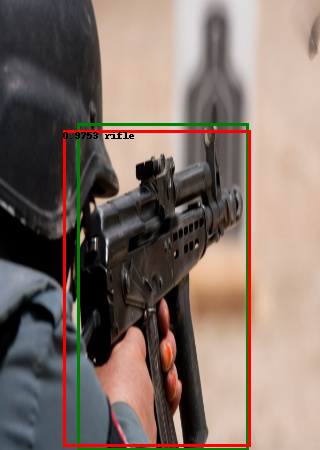

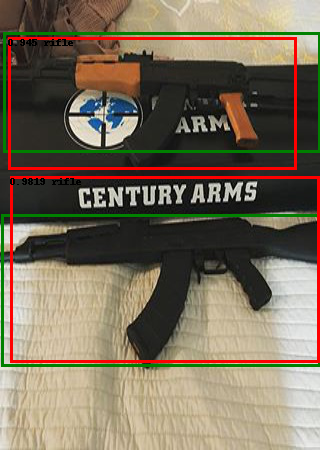

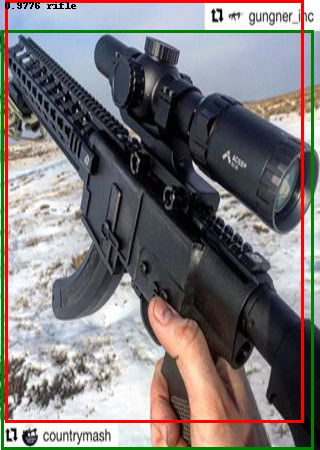

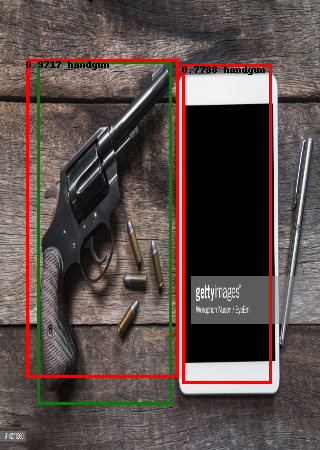

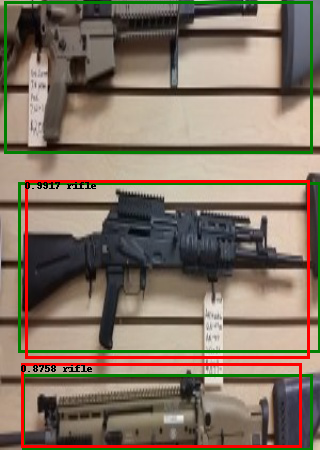

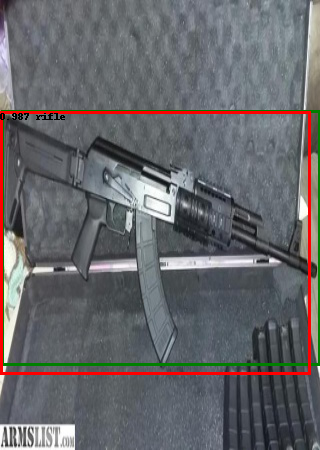

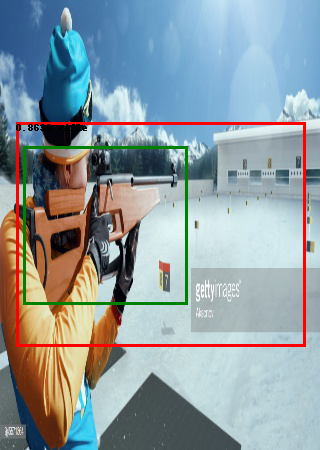

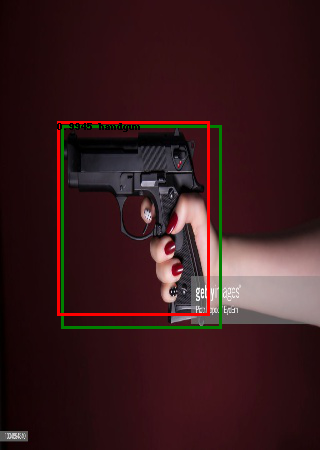

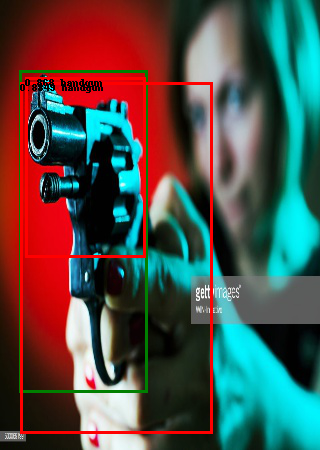

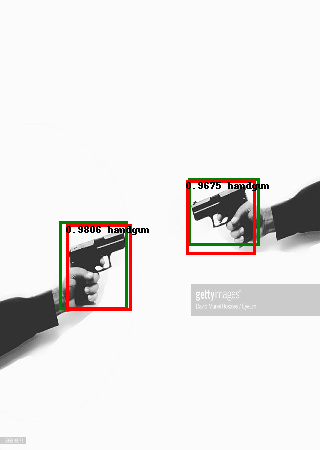

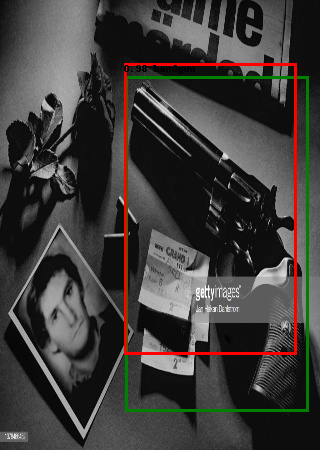

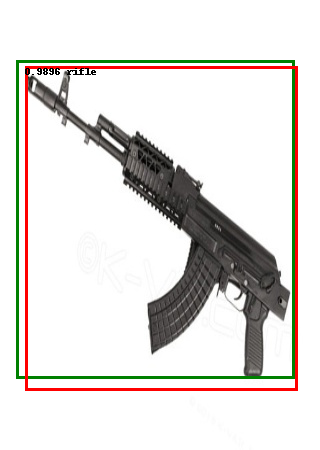

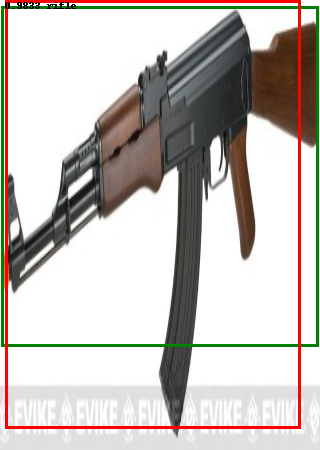

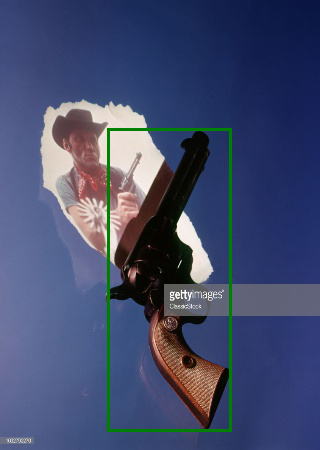

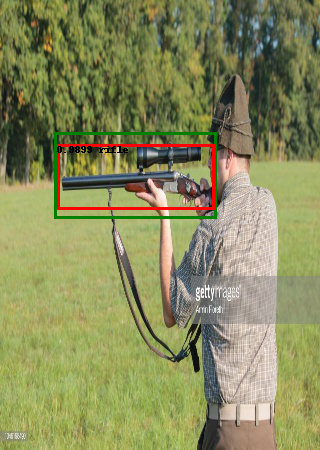

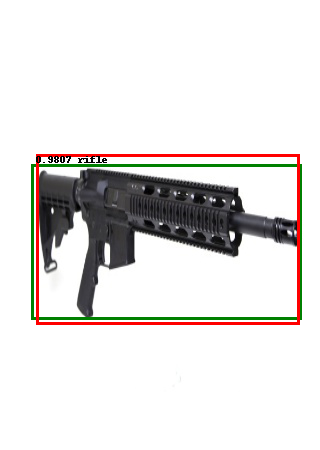

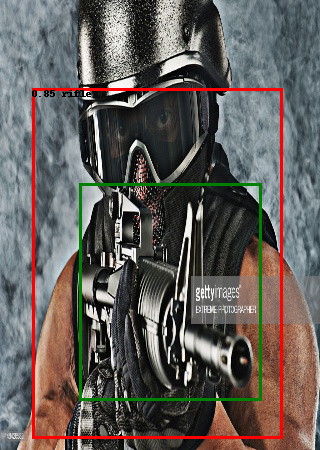

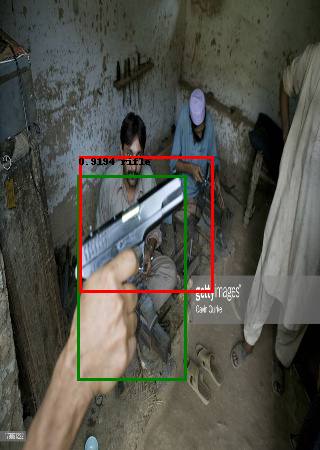

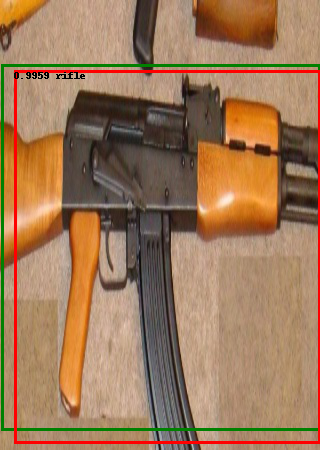

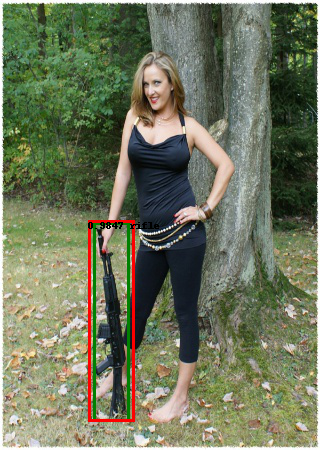

In [43]:
#idx = 1
for idx in range(20):

    img, _ = dataset_test[idx]
    label_boxes = np.array(dataset_test[idx][1]["boxes"])
    #put the model in evaluation mode
    loaded_model.eval()
    with torch.no_grad():
        prediction = loaded_model([img])
    image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
    draw = ImageDraw.Draw(image)

    cat_rev = {cat[o]: o for o in cat}
    # draw groundtruth
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
        (label_boxes[elem][2], label_boxes[elem][3])], 
        outline ="green", width =3)
        
    for element in range(len(prediction[0]["boxes"])):

        boxes = prediction[0]["boxes"][element].cpu().numpy()
        score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                        decimals= 4)
        if score > 0.7:
            draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline ="red", width =3)
            draw.text((boxes[0], boxes[1]), text = str(score)+ " " + cat_rev[np.int(prediction[0]["labels"][element])] , fill="#000")
    display(image)


In [44]:
# To load trained model
path_trnd_model = "drive/MyDrive/trainedModels"
loaded_model2,_,_ = load_checkpoint(get_model(num_classes = 3), filename=path_trnd_model+"/model_3Classes_10epochs")

=> loading checkpoint 'drive/MyDrive/trainedModels/model_3Classes_10epochs'
=> loaded checkpoint 'drive/MyDrive/trainedModels/model_3Classes_10epochs' (epoch 9)


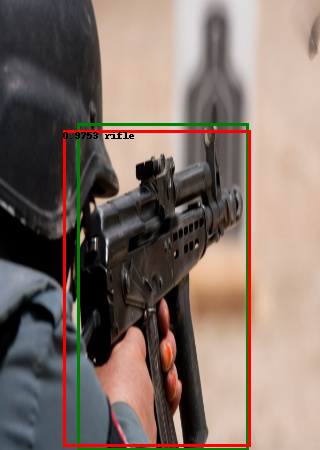

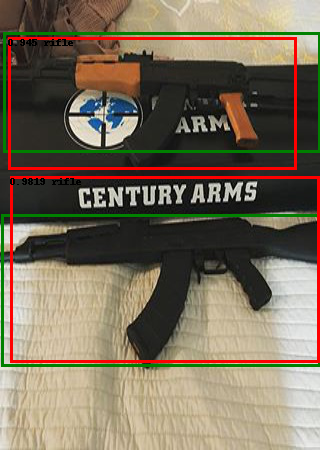

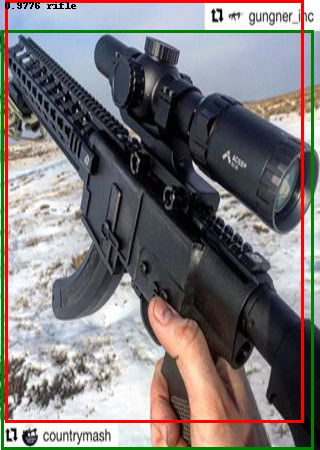

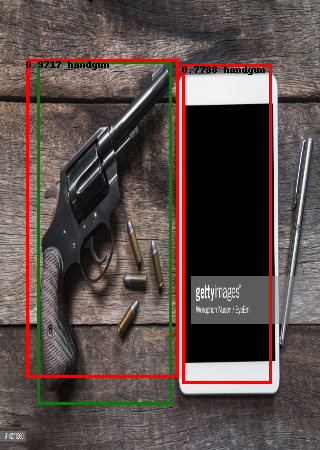

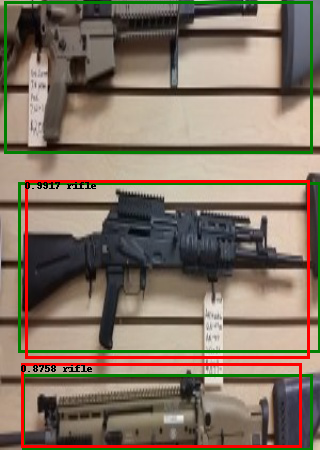

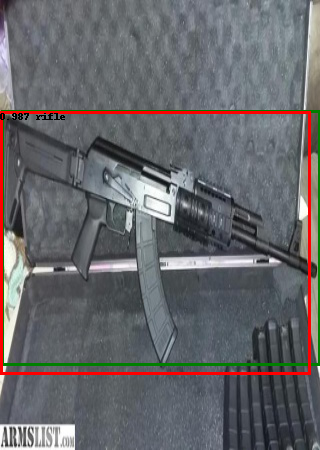

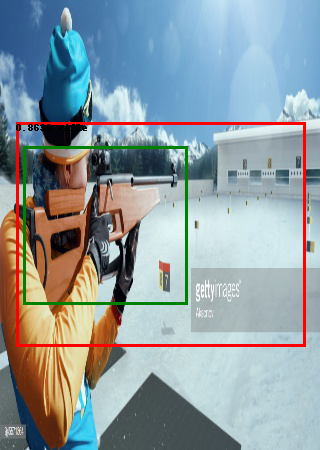

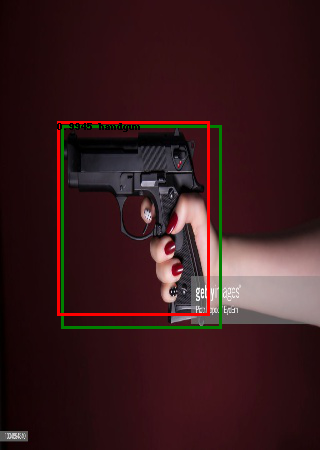

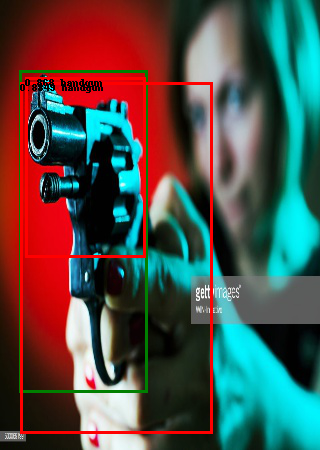

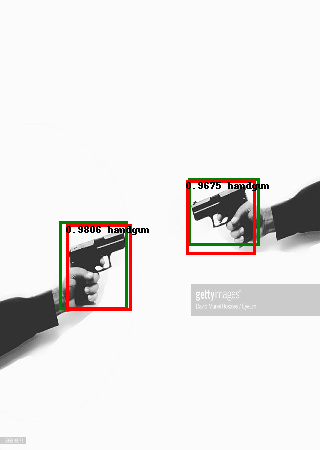

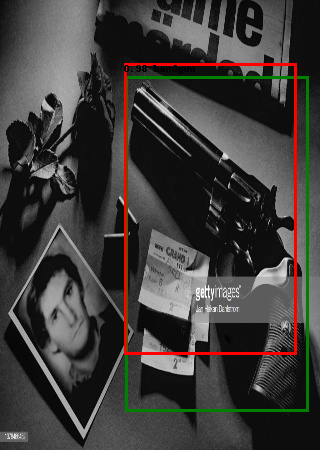

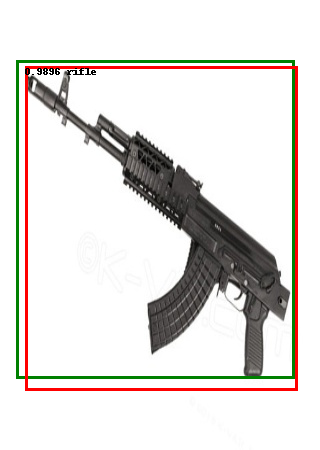

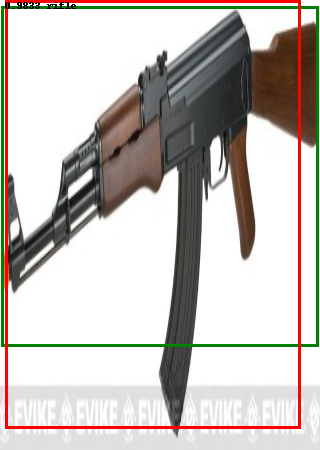

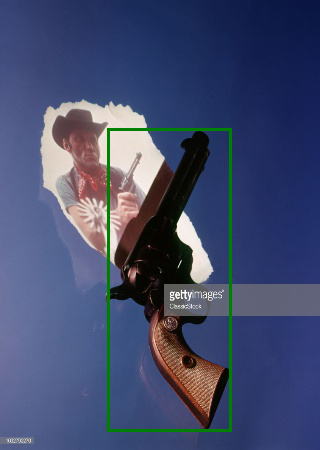

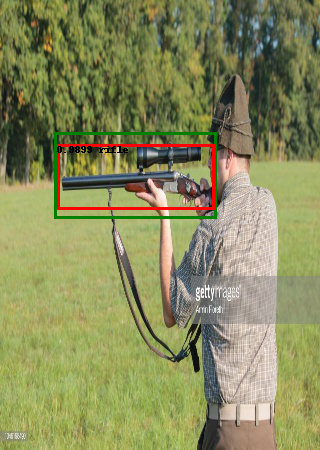

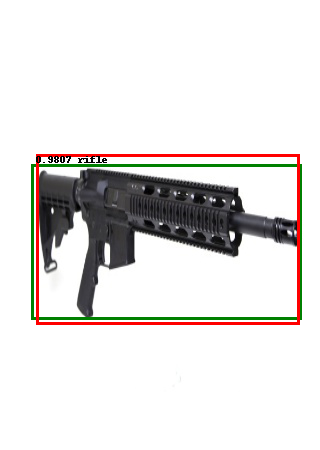

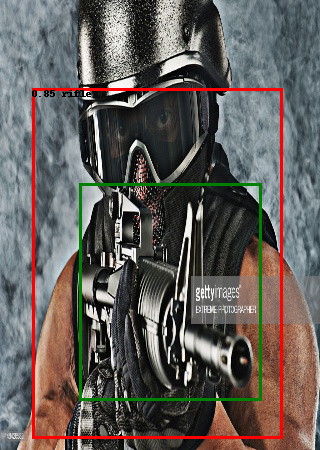

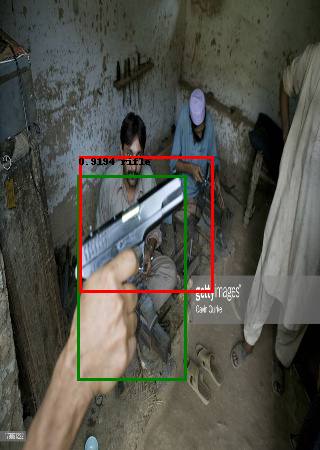

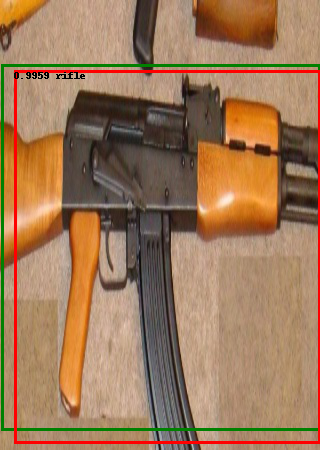

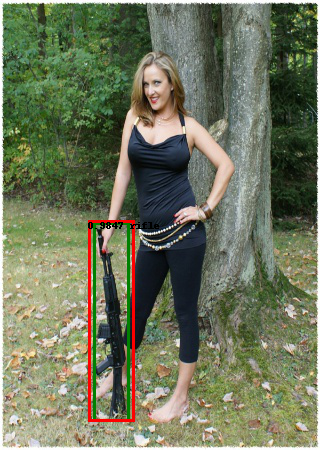

In [45]:
#idx = 1

for idx in range(20):

    img, _ = dataset_test[idx]
    label_boxes = np.array(dataset_test[idx][1]["boxes"])
    #put the model in evaluation mode
    loaded_model2.eval()
    with torch.no_grad():
        prediction = loaded_model2([img])
    image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
    draw = ImageDraw.Draw(image)

    cat_rev = {cat[o]: o for o in cat}
    # draw groundtruth
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
        (label_boxes[elem][2], label_boxes[elem][3])], 
        outline ="green", width =3)
        
    for element in range(len(prediction[0]["boxes"])):

        boxes = prediction[0]["boxes"][element].cpu().numpy()
        score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                        decimals= 4)
        if score > 0.7:
            draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline ="red", width =3)
            draw.text((boxes[0], boxes[1]), text = str(score)+ " " + cat_rev[np.int(prediction[0]["labels"][element])] , fill="#000")
    display(image)